In [1]:
#%display latex

In [2]:
# sage comes with a built-in pip:
# ~/Programs/SageMath/sage --pip install dill
# installed sage via jupyter kernelspec install --user ./SageMath/local/share/jupyter/kernels/
import dill
import pickle
from transmembrane_lib import *


from scipy.integrate import odeint
from sympy.plotting import plot
from sympy import init_printing
import sympy
from sympy.abc import t
from sympy import Array, Sum, Indexed, IndexedBase, Idx
init_printing()
from sympy.abc import t # x is the independent variable
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, exp, pi, diff, Poly
from sympy.physics.units.systems import SI
from sympy.physics.units import length, mass, acceleration, force
from sympy.physics.units import gravitational_constant as G
from sympy.physics.units.systems.si import dimsys_SI
import sympy.physics.units as units
#import pprint as pps
import sympy
import sympy.physics.units.util as util
from dataclasses import dataclass
from sympy.simplify.radsimp import collect
from sympy.assumptions.refine import refine
from sympy import init_printing
from sympy.simplify.powsimp import powsimp
init_printing()
from scipy.integrate import odeint
from sympy.plotting import plot
from sympy import init_printing
import sympy
from sympy.abc import t
from sympy import Array, Sum, Indexed, IndexedBase, Idx
init_printing()
from sympy.abc import t # x is the independent variable
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, exp, pi, diff, Poly

def convexp(name, val):
    return Eq(sympy.S(name), val, evaluate=False)

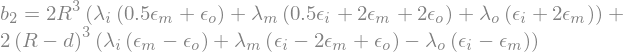

In [3]:
e_o, e_i, e_m = symbols(("epsilon_o", "epsilon_i", "epsilon_m"))

R, l_o, l_i, l_m, d, a_1, a_2, a_3, b_1, b_2, b_3 = symbols("R lambda_o lambda_i lambda_m d a_1 a_2 a_3 b_1 b_2 b_3")
#     e_o = extracellular_permittivity * eps0 # S/m
#     e_i = intracellular_permittivity * eps0 #S/m
#     e_m = membrane_permittivity * eps0 #S/m
#     R = cell_diameter / 2
#     R = R

#     l_o = extracellular_conductivity*Spm # S/m
#     l_i = intracellular_conductivity*Spm #S/m
#     l_m = membrane_conductivity*Spm #S/m

#     d = membrane_thickness

sub1, sub2 = symbols('sub1 sub2')
sub1 = (3 * (R**2) - 3 * d * R + d**2)
sub2 = (3 * d * R - d**2)

a_1 = 3 * d * l_o * ((l_i * (sub1)) + l_m*(sub2)) #eq.9a
a_2 = 3 * d * ((l_i * e_o + l_o * e_i) * sub1 + (l_m * e_o + l_o * e_m) * sub2)
a_3 = 3 * d * e_o * (e_i * (sub1) + e_m * sub2)

b_1 = 2 * R**3 * (l_m + 2*l_o) * (l_m + (1/2) * l_i) + 2 * (R-d)**3 * (l_m - l_o) * (l_i - l_m)

b_2 = 2 * R**3 * (l_i * ((1/2) * e_m + e_o) + l_m * ((1/2)*e_i + 2*e_m + 2*e_o) + l_o * (e_i + 2 * e_m)) + (2 * (R - d)**3\
* (l_i * (e_m - e_o) + l_m * (e_i - 2*e_m + e_o) - l_o * (e_i - e_m))) # is this truly a multiply, or a cross?


b_3 = 2 * R**3 * (e_m + 2*e_o) * (e_m + (1/2) * e_i) + 2 * (R-d)**3 * (e_m - e_o) * (e_i - e_m)


display(convexp("a_1", a_1))
display(convexp("a_2", a_2))
display(convexp("a_3", a_3))

display(convexp("b_1", b_1))
display(convexp("b_2", b_2))
display(convexp("b_3", b_3))

alpha = ((R*a_3/b_3))
beta = ((R*a_2/b_3))
gamma = ((R*a_1/b_3))
phi = ((b_2/b_3))
xi = ((b_1/b_3))


display(convexp("b_1", b_1))
display(convexp("b_2", b_2))
display(convexp("b_3", b_3))


Where ${\lambda_m}$ is conductivity

# Transfer function to differential equation

**[originally in gekko_optimal_control.py]**

For convenience, let's convert the Kotnik transfer function to standard DE form, following the guide here: https://lpsa.swarthmore.edu/Representations/SysRepTransformations/TF2SDE.html

originally (mistakenly) used A6c (1998). Switched to eq 8, (multiplied by R, eq 10).
also missed switching the top and bottom: the top goes with the input terms (right) and the bottom with the output.


`H(s)= (R*X(s)) / U(s) = (R a3 s^2 + R a2 s + R a3) / (b3 s^2 + b2 s + b1)`


> "Separate the equation so that the output terms, X(s), are on the
left and the input terms, Fa(s), are on the right.  Make sure there are only positive powers of s."

`(b3 s^2 + b2 s + b1) X(s) = (R a3 s^2 + R a2 s + R a3) U(s)`

> "Now take the inverse Laplace Transform (so multiplications by "s" in the Laplace domain are replaced by derivatives in time)."

`b3 x'' + b2 x' + b1 x = R a3 u'' + R a2 u' + R a3 u`

where u is the input function,

Most solvers like gekko want the equation in first order, so we have to substitute in a new state variable representing the first derivative, converting to a system of DEs.

http://www.math.utah.edu/~gustafso/2250systems-de.pdf
http://www.sharetechnote.com/html/DE_HigherOrderDEtoFirstOrderDE.html
https://math.berkeley.edu/~zworski/128/psol12.pdf

https://math.stackexchange.com/questions/1120984/

(reworked because I found the notation confusing (u2 should be the second derivative!))

```
u0 = u
u1 = u'
u2 = u''

      x0 = x
x0' = x1 = x'
x1' = x2 = x'' =

    b3 x'' + b2 x' + b1 x = R a3 u'' + R a2 u' + R a3 u
    x''  = (R a3 u'' + R a2 u' + R a3 u - b2 x' - b1 x)/b3
    x2  = (R*a3*u2 + R*a2*u1 + R*a3*u0 - b2*x1 - b1*x0)/b3

```

docs: "In all simulation modes (IMODE=1,4,7), the number of equations must equal the number of variables."




(add convolution integral thing here)

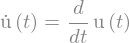

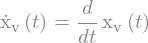

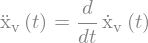

In [4]:
x0_v = Function("{x}_v", )
x1_v = Function("{\dot{x}_v}")
x2_v = Function("{\ddot{x}_v}")
u0 = Function("{u}")
u1 = Function("{\dot{u}}")
u2 = Function("{\ddot{u}}")

alpha_v, beta_v, gamma_v, phi_v, xi_v = symbols("alpha_v, beta_v, gamma_v, phi_v, xi_v")

display(Eq(u1(t),diff(u0(t),t)))

display(Eq(x1_v(t),diff(x0_v(t),t)))
display(Eq(x2_v(t),diff(x1_v(t),t)))
virus_ODE_d2 = Eq(x2_v(t), (alpha_v*u2(t) + beta_v*u1(t) + gamma_v*u0(t) - phi_v*x1_v(t) - xi_v*x0_v(t)))
display(virus_ODE_d2)

g 

# Yen and Nagurka

In [5]:

t, 𝛂, 𝛃, 𝛄, 𝛙, 𝛏, C1, C2, M, J = symbols("t alpha beta gamma phi xi C1 C2  M J")
p_0, p_1, p_2, p_3, p_4, p_5 = symbols("p_0 p_1 p_2 p_3 p_4 p_5")
a_1, b_1 = symbols("a_1, b_1")
t_f = symbols(("t_f"))
j,m,k = symbols("j m k")

P = Function('P')
p = IndexedBase('p')
P = Sum(p[j]*t**j,(j,0,5))#sympy chokes on all of these


λ = Function('lamda')
a = IndexedBase('a')
b = IndexedBase('b')

λ = Sum(a[m] * cos(2 * m * pi * t / t_f), (m, 1, M)) + Sum(b[m] * sin(2 * m * pi * t / t_f), (m, 1, M))

# sympy.pprint(λ)
# sympy.pprint(diff(λ, t))
# sympy.pprint(diff(λ, t, t))

X = P + λ

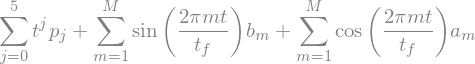

In [6]:
X

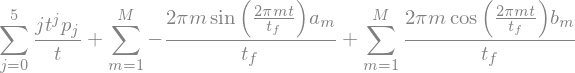

In [7]:
diff(X , t)

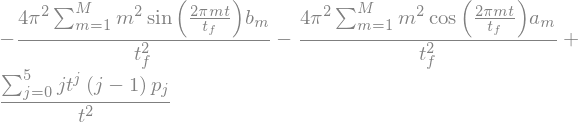

In [8]:
diff(X , t, t)

# Method of undetermined coefficients


In the inverse-dynamic use by Yen&Nagurka,
the fourier series + polynomial define one time-course of one of the x outputs.

We want to obtain the u control input (and the other x output, of course), and then
the cost function J.

Unfortunately, both sympy and maxima choke on solving the DE for U after the fourier series,
even though this DE really should be analytic.

One could easily numerically integrate the problem, as discussed in one of Nagurka and Yen's examples
 - but that's boring and kinda defeats the purpose of using this high-accuracy analytic parametrization.

```
x2_v = 𝛂ᵥ*u2 + 𝛃ᵥ*u1 + 𝛄ᵥ*u0 - 𝛙ᵥ*x1_v - 𝛏ᵥ*x0_v




d²xᵥ/dt² = 𝛂*d²u/dt² + 𝛃*du/dt + 𝛄*u - 𝛙*dxᵥ/dt - 𝛏*xᵥ
𝛏*xᵥ = 𝛂*d²u/dt² + 𝛃*du/dt + 𝛄*u - 𝛙*dxᵥ/dt - d²xᵥ/dt²


𝛏xᵥ = 𝛂ü + 𝛃u̇ + 𝛄u - 𝛙ẋᵥ - ẍᵥ
```

We approximate xᵥ by Nagurka, Eq. 13:

```
xᵥ(t) = P(t) + λ(t)

    5
P = ∑ p_j
   j=0

    M
λ = ∑ a cos + b sin
   m=1
```

there is a subtlty here in that the derivative of a fourier series may not equal the term-by-term derivative.
https://math.stackexchange.com/questions/1754033/integration-and-differentiation-of-fourier-series
this is explicitly addressed in nagurka. this might be why the CASes choked - the terms that
ensure differentiability weren't known to it

```
𝛂ü + 𝛃u̇ + 𝛄u = 𝛏(P + λ)  + 𝛙ẋᵥ + ẍᵥ
```

now that's nothing more than the harmonic oscillator.

http://web.uvic.ca/~monahana/ode_1_flowchart.pdf
http://web.uvic.ca/~monahana/ode_2_flowchart.pdf
a brilliant ode flowchart!

this is a nonhomogenous differential equation.
Is the ODE linear? Yes.

```
𝛂ü + 𝛃u̇ + 𝛄u = 𝛏(P + λ) + 𝛙d(P + λ)/dt + d²(P + λ)/dt²
```
let us put it in standard form:

```
ü + 𝛃/𝛂u̇ + 𝛄/𝛂u = (𝛏/𝛂)(P + λ) + (𝛙/𝛂)d(P + λ)/dt + (1/𝛂)d²(P + λ)/dt²
```

The ODE is non-homogeneous.

> "The solution is of form y(x) = yp(x) + yc(x) where yp(x) is a particular solution and yc(x) is
the solution of the associated homogeneous ODE."

> "Find yc(x) by going back to Step 1." Homogeneous ODE:

```
ü + 𝛃/𝛂u̇ + 𝛄/𝛂u = 0
```

define two new constants,

```
A = 𝛃/𝛂
B = 𝛄/𝛂
```

typical values for

```
𝛂=1.3e-08
𝛃=5.7
𝛄=4e7
```
```
A² - 4B = 1e17
```

therefore, case A:


> yc(t) = c₁e^(m₁t) + c₂e^(m₂t)


(I knew I would mess up beta and B, man, lack of CAS is hurting).

(spoiler alert: We actually didn't need yc at all, it seems)

> "Is g(x) a sum/product of constants, polynomials, exponentials, and sine/cosine
functions?" 

Yes.

> "Can find yp(x) using method of undetermined coefficients. Let the functions hi(x) be made
up of the functions in g(x) and their derivatives. 
> Do any of the hi(x) belong to the fundamental set y1(x), y2(x) of the homogeneous ODE?"

https://tutorial.math.lamar.edu/classes/de/undeterminedcoefficients.aspx


# Pore formation

**[previously at transmembrane_lib.py and nagurka_math_2.py]**

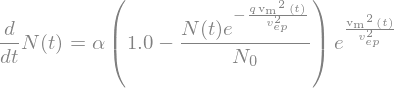

In [17]:
v_m,alpha,N0,q,v_ep, N_ic = symbols("v_m,alpha,N0,q,v_ep, N_ic", real=True)
N = Function('N')
v_m = Function('v_m')(t)

# v_m = sympy.simplify(solution.rhs)

k = (v_m/v_ep)**2

LHS = diff(N(t),t)
RHS = alpha * exp(k) * (1.0 - (N(t)/N0)*exp(-q*k))

dN_dt = Eq(LHS, RHS)

# adding W(t_f): W_tf, W(t).diff(t,1).subs(t,t_f): d_W_tf}
# raises ValueError: Couldn't solve for initial conditions

# sympy.pprint(sympy.simplify(solution))
display(dN_dt)

Strictly for the cost function, this can perhaps be simplified to 


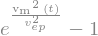

In [19]:
exp(k) - 1

In [10]:

solution = dsolve(Eq(LHS, RHS), N(t), ics={N(0): N_ic})


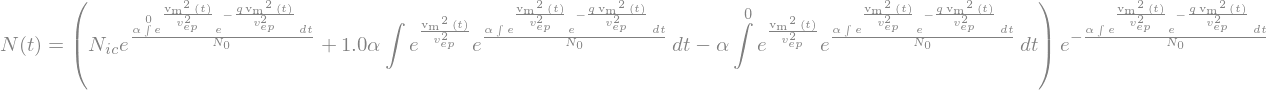

In [11]:
solution

# Pore current

where $\text{v}_m$ is the normalized version

if I'm not wrong, eq 14 in Talele has a typo compared to DeBruin: 

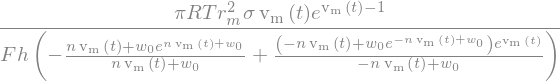

In [22]:
w0,F,R,T,r_m,diameter,h,sigma,n,N,k = symbols("w0,F,R,T,r_m,diameter,h,sigma,n,N,k")
v_m = Function('v_m')

#v_m = (V_m(t)) * (F/(R*T))

v_m = v_m(t)

i_ep_term_1 = (pi * (r_m**2) * sigma * v_m * R * T) / (F * h)

i_ep_term_2_divisor_1 = exp(v_m)*((w0*exp(w0-n*v_m) - (n*v_m)) / (w0 - (n*v_m)))
i_ep_term_2_divisor_2 = -((w0*exp(w0+n*v_m) + (n*v_m)) / (w0 + (n*v_m)))
i_ep_term_2 = exp(v_m - 1) / (i_ep_term_2_divisor_1 + i_ep_term_2_divisor_2)

i_ep = i_ep_term_1 * i_ep_term_2

i_ep

## Incorrect pore formulation

capacitor 

In [26]:

# I = C_m dv/dt
# dv_dt = I/C_m
# permittivity already has the eps0 in it
A = 4*pi*(diameter/2)**2
C_m = k * A / h
dV_dt_ep = -(i_ep * N / C_m)

# I_ep # Requires sage

In [24]:
# print(I_ep.diff(t)) # Requires sage

In [25]:
# print(simplify(simplify((I_ep.diff(t))._sage_())))#.canonicalize_radical() # Requires sage

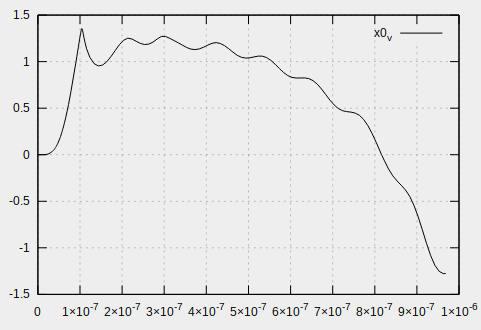



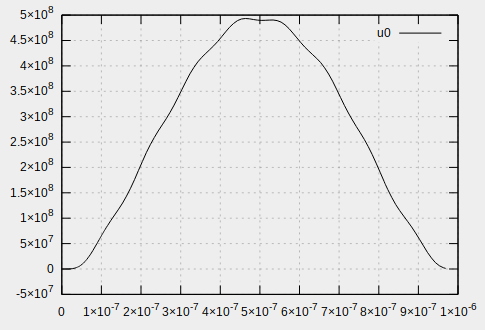

Though the initial "snap" is correctly represented, the decay of x0v below 0 on the falling edge is clearly just wrong. 

# Correct pore formation formulation

As specified by Talele et al, 

In [36]:

symbols("I_ep V_m")

l_m_pore = l_m + (I_ep / x0_v)

# talele switch from gp to sigmap - is there a conversion happening there?

l_m_ep = 

# I_ep = (i_ep * N)

SyntaxError: invalid syntax (<ipython-input-36-1004a41a4932>, line 7)

# Nondimensionalization, attempt 2

- Scale all terms in the virus by the ratio of the diameter?